In [1]:
import os, torch, torchaudio, pandas as pd
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
# -----------------------------
# Environment Setup
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bundle = torchaudio.pipelines.WAV2VEC2_BASE
wav2vec_model = bundle.get_model().to(device).eval()

In [3]:
# -----------------------------
# Configurations
# -----------------------------
TRAIN_AUDIO_DIR = "../dataset/audios_train"
TEST_AUDIO_DIR = "../dataset/audios_test"
TRAIN_CSV_PATH = "../dataset/train.csv"
TEST_CSV_PATH = "../dataset/test.csv"

FINAL_MODEL_PATH = "final_transformer_model.pt"
PREDICTIONS_CSV = "test_predictions_transformers_submit.csv"

BEST_LEARNING_RATE = 5e-4
BEST_BATCH_SIZE = 8
BEST_EPOCHS = 50
BEST_NUM_HEADS = 4
BEST_NUM_LAYERS = 3
BEST_HIDDEN_DIM = 256
BEST_DROPOUT = 0.3

In [4]:
# -----------------------------
# Dataset Class
# -----------------------------
class AudioDataset(Dataset):
    def __init__(self, csv_path, audio_dir, is_test=False):
        self.df = pd.read_csv(csv_path)
        self.audio_dir = audio_dir
        self.is_test = is_test

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        waveform, sr = torchaudio.load(os.path.join(self.audio_dir, row['filename']))
        if sr != bundle.sample_rate:
            waveform = torchaudio.transforms.Resample(sr, bundle.sample_rate)(waveform)
        if waveform.shape[0] > 1:
            waveform = waveform.mean(dim=0, keepdim=True)
        waveform = waveform.to(device)

        if self.is_test:
            return waveform, row['filename']
        else:
            label = torch.tensor(float(row['label']), dtype=torch.float32).to(device)
            return waveform, label

In [5]:
# -----------------------------
# Transformer-Based Regressor
# -----------------------------
class TransformerRegressor(nn.Module):
    def __init__(self, input_dim, num_heads, num_layers, hidden_dim, dropout):
        super().__init__()
        self.encoder_layer = nn.TransformerEncoderLayer(
            d_model=input_dim,
            nhead=num_heads,
            dim_feedforward=hidden_dim,
            dropout=dropout,
            activation="gelu",
            batch_first=True
        )
        self.encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)

        self.attn_pool = nn.Sequential(
            nn.Linear(input_dim, 1),
            nn.Softmax(dim=1)
        )

        self.regressor = nn.Sequential(
            nn.LayerNorm(input_dim),
            nn.Linear(input_dim, 1)
        )

    def forward(self, x):  # x: [B, T, D]
        x = self.encoder(x)  # [B, T, D]
        attn_weights = self.attn_pool(x)  # [B, T, 1]
        pooled = (attn_weights * x).sum(dim=1)  # [B, D]
        return self.regressor(pooled).squeeze(1)

In [6]:
# -----------------------------
# Feature Extraction
# -----------------------------
def extract_sequence_features(waveform):
    with torch.no_grad():
        if waveform.dim() == 3:
            waveform = waveform.squeeze(1)
        features, _ = wav2vec_model.extract_features(waveform)
        return features[-1]  # [B, T, D]

In [7]:
# -----------------------------
# Collate Functions
# -----------------------------
def collate_fn_train(batch):
    waveforms = [x[0] for x in batch]
    labels = torch.stack([x[1] for x in batch])
    features = [extract_sequence_features(wf.unsqueeze(0)).squeeze(0).cpu() for wf in waveforms]
    features_padded = pad_sequence(features, batch_first=True)  # [B, T, D]
    return features_padded.to(device), labels

def collate_fn_test(batch):
    waveforms = [x[0] for x in batch]
    filenames = [x[1] for x in batch]
    features = [extract_sequence_features(wf.unsqueeze(0)).squeeze(0).cpu() for wf in waveforms]
    features_padded = pad_sequence(features, batch_first=True)
    return features_padded.to(device), filenames

In [8]:
# -----------------------------
# Training Function
# -----------------------------
def train_model():
    train_dataset = AudioDataset(TRAIN_CSV_PATH, TRAIN_AUDIO_DIR, is_test=False)
    train_loader = DataLoader(train_dataset, batch_size=BEST_BATCH_SIZE, shuffle=True, collate_fn=collate_fn_train)

    # Get input_dim from dummy input
    input_dim = extract_sequence_features(torch.randn(1, 16000).to(device)).shape[2]
    model = TransformerRegressor(
        input_dim=input_dim,
        num_heads=BEST_NUM_HEADS,
        num_layers=BEST_NUM_LAYERS,
        hidden_dim=BEST_HIDDEN_DIM,
        dropout=BEST_DROPOUT
    ).to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=BEST_LEARNING_RATE)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.9, patience=2, min_lr=1e-6)
    criterion = nn.MSELoss()

    print("🚀 Starting training...")
    for epoch in range(BEST_EPOCHS):
        model.train()
        total_loss = 0.0
        for feats, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{BEST_EPOCHS} [Train]"):
            preds = model(feats)
            loss = criterion(preds, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch+1}: Train Loss = {avg_loss:.4f} | LR = {current_lr:.6f}")
        scheduler.step(avg_loss)

    torch.save(model.state_dict(), FINAL_MODEL_PATH)
    print(f"✔️ Final model saved to {FINAL_MODEL_PATH}")

In [9]:
# -----------------------------
# Evaluation Function
# -----------------------------
def evaluate_model():
    if not os.path.exists(FINAL_MODEL_PATH):
        print(f"❌ Error: Model not found at {FINAL_MODEL_PATH}")
        return

    test_dataset = AudioDataset(TEST_CSV_PATH, TEST_AUDIO_DIR, is_test=True)
    test_loader = DataLoader(test_dataset, batch_size=BEST_BATCH_SIZE, shuffle=False, collate_fn=collate_fn_test)

    input_dim = extract_sequence_features(torch.randn(1, 16000).to(device)).shape[2]
    model = TransformerRegressor(
        input_dim=input_dim,
        num_heads=BEST_NUM_HEADS,
        num_layers=BEST_NUM_LAYERS,
        hidden_dim=BEST_HIDDEN_DIM,
        dropout=BEST_DROPOUT
    ).to(device)
    model.load_state_dict(torch.load(FINAL_MODEL_PATH))
    model.eval()

    all_preds = []
    all_filenames = []

    print("🔍 Evaluating model...")
    with torch.no_grad():
        for feats, filenames in tqdm(test_loader, desc="Evaluation"):
            preds = model(feats)
            all_preds.extend(preds.cpu().numpy())
            all_filenames.extend(filenames)

    output_df = pd.DataFrame({
        'filename': all_filenames,
        'label': all_preds
    })
    output_df.iloc[:, 1] = output_df.iloc[:, 1].apply(lambda x: round(x * 2) / 2)
    output_df.to_csv(PREDICTIONS_CSV, index=False)
    print(f"✔️ Predictions saved to {PREDICTIONS_CSV}")

In [10]:
# -----------------------------
# Entry Point
# -----------------------------
if __name__ == "__main__":
    train_model()
    evaluate_model()

🚀 Starting training...


Epoch 1/50 [Train]: 100%|██████████| 56/56 [06:16<00:00,  6.73s/it]


Epoch 1: Train Loss = 2.5406 | LR = 0.000500


Epoch 2/50 [Train]: 100%|██████████| 56/56 [06:17<00:00,  6.75s/it]


Epoch 2: Train Loss = 1.2797 | LR = 0.000500


Epoch 3/50 [Train]: 100%|██████████| 56/56 [06:20<00:00,  6.80s/it]


Epoch 3: Train Loss = 1.1199 | LR = 0.000500


Epoch 4/50 [Train]: 100%|██████████| 56/56 [06:17<00:00,  6.74s/it]


Epoch 4: Train Loss = 0.9179 | LR = 0.000500


Epoch 5/50 [Train]: 100%|██████████| 56/56 [05:51<00:00,  6.28s/it]


Epoch 5: Train Loss = 0.8617 | LR = 0.000500


Epoch 6/50 [Train]: 100%|██████████| 56/56 [06:32<00:00,  7.00s/it]


Epoch 6: Train Loss = 0.7966 | LR = 0.000500


Epoch 7/50 [Train]: 100%|██████████| 56/56 [06:34<00:00,  7.05s/it]


Epoch 7: Train Loss = 0.6984 | LR = 0.000500


Epoch 8/50 [Train]: 100%|██████████| 56/56 [06:33<00:00,  7.02s/it]


Epoch 8: Train Loss = 0.6679 | LR = 0.000500


Epoch 9/50 [Train]: 100%|██████████| 56/56 [06:23<00:00,  6.85s/it]


Epoch 9: Train Loss = 0.5786 | LR = 0.000500


Epoch 10/50 [Train]: 100%|██████████| 56/56 [06:12<00:00,  6.65s/it]


Epoch 10: Train Loss = 0.5510 | LR = 0.000500


Epoch 11/50 [Train]: 100%|██████████| 56/56 [06:35<00:00,  7.06s/it]


Epoch 11: Train Loss = 0.5162 | LR = 0.000500


Epoch 12/50 [Train]: 100%|██████████| 56/56 [06:13<00:00,  6.67s/it]


Epoch 12: Train Loss = 0.5579 | LR = 0.000500


Epoch 13/50 [Train]: 100%|██████████| 56/56 [06:06<00:00,  6.54s/it]


Epoch 13: Train Loss = 0.5133 | LR = 0.000500


Epoch 14/50 [Train]: 100%|██████████| 56/56 [06:19<00:00,  6.78s/it]


Epoch 14: Train Loss = 0.4283 | LR = 0.000500


Epoch 15/50 [Train]: 100%|██████████| 56/56 [06:17<00:00,  6.74s/it]


Epoch 15: Train Loss = 0.4243 | LR = 0.000500


Epoch 16/50 [Train]: 100%|██████████| 56/56 [06:09<00:00,  6.60s/it]


Epoch 16: Train Loss = 0.4368 | LR = 0.000500


Epoch 17/50 [Train]: 100%|██████████| 56/56 [06:21<00:00,  6.82s/it]


Epoch 17: Train Loss = 0.3981 | LR = 0.000500


Epoch 18/50 [Train]: 100%|██████████| 56/56 [06:10<00:00,  6.61s/it]


Epoch 18: Train Loss = 0.3381 | LR = 0.000500


Epoch 19/50 [Train]: 100%|██████████| 56/56 [06:30<00:00,  6.97s/it]


Epoch 19: Train Loss = 0.4803 | LR = 0.000500


Epoch 20/50 [Train]: 100%|██████████| 56/56 [06:35<00:00,  7.05s/it]


Epoch 20: Train Loss = 0.3851 | LR = 0.000500


Epoch 21/50 [Train]: 100%|██████████| 56/56 [06:26<00:00,  6.89s/it]


Epoch 21: Train Loss = 0.5245 | LR = 0.000500


Epoch 22/50 [Train]: 100%|██████████| 56/56 [06:12<00:00,  6.66s/it]


Epoch 22: Train Loss = 0.6388 | LR = 0.000450


Epoch 23/50 [Train]: 100%|██████████| 56/56 [06:34<00:00,  7.04s/it]


Epoch 23: Train Loss = 0.7004 | LR = 0.000450


Epoch 24/50 [Train]: 100%|██████████| 56/56 [06:31<00:00,  7.00s/it]


Epoch 24: Train Loss = 0.5932 | LR = 0.000450


Epoch 25/50 [Train]: 100%|██████████| 56/56 [05:58<00:00,  6.39s/it]


Epoch 25: Train Loss = 0.6337 | LR = 0.000405


Epoch 26/50 [Train]: 100%|██████████| 56/56 [06:15<00:00,  6.71s/it]


Epoch 26: Train Loss = 0.6323 | LR = 0.000405


Epoch 27/50 [Train]: 100%|██████████| 56/56 [06:25<00:00,  6.89s/it]


Epoch 27: Train Loss = 0.6336 | LR = 0.000405


Epoch 28/50 [Train]: 100%|██████████| 56/56 [06:05<00:00,  6.52s/it]


Epoch 28: Train Loss = 0.6613 | LR = 0.000365


Epoch 29/50 [Train]: 100%|██████████| 56/56 [06:34<00:00,  7.05s/it]


Epoch 29: Train Loss = 0.6365 | LR = 0.000365


Epoch 30/50 [Train]: 100%|██████████| 56/56 [06:39<00:00,  7.14s/it]


Epoch 30: Train Loss = 0.5808 | LR = 0.000365


Epoch 31/50 [Train]: 100%|██████████| 56/56 [06:24<00:00,  6.87s/it]


Epoch 31: Train Loss = 0.5275 | LR = 0.000328


Epoch 32/50 [Train]: 100%|██████████| 56/56 [06:32<00:00,  7.01s/it]


Epoch 32: Train Loss = 0.5603 | LR = 0.000328


Epoch 33/50 [Train]: 100%|██████████| 56/56 [06:13<00:00,  6.68s/it]


Epoch 33: Train Loss = 0.6994 | LR = 0.000328


Epoch 34/50 [Train]: 100%|██████████| 56/56 [06:39<00:00,  7.13s/it]


Epoch 34: Train Loss = 0.5281 | LR = 0.000295


Epoch 35/50 [Train]: 100%|██████████| 56/56 [06:28<00:00,  6.95s/it]


Epoch 35: Train Loss = 0.4917 | LR = 0.000295


Epoch 36/50 [Train]: 100%|██████████| 56/56 [06:22<00:00,  6.83s/it]


Epoch 36: Train Loss = 0.4537 | LR = 0.000295


Epoch 37/50 [Train]: 100%|██████████| 56/56 [06:36<00:00,  7.08s/it]


Epoch 37: Train Loss = 0.4744 | LR = 0.000266


Epoch 38/50 [Train]: 100%|██████████| 56/56 [05:59<00:00,  6.41s/it]


Epoch 38: Train Loss = 0.4010 | LR = 0.000266


Epoch 39/50 [Train]: 100%|██████████| 56/56 [06:06<00:00,  6.55s/it]


Epoch 39: Train Loss = 0.3788 | LR = 0.000266


Epoch 40/50 [Train]: 100%|██████████| 56/56 [06:15<00:00,  6.71s/it]


Epoch 40: Train Loss = 0.3680 | LR = 0.000239


Epoch 41/50 [Train]: 100%|██████████| 56/56 [06:24<00:00,  6.87s/it]


Epoch 41: Train Loss = 0.3401 | LR = 0.000239


Epoch 42/50 [Train]: 100%|██████████| 56/56 [06:12<00:00,  6.65s/it]


Epoch 42: Train Loss = 0.3197 | LR = 0.000239


Epoch 43/50 [Train]: 100%|██████████| 56/56 [06:33<00:00,  7.02s/it]


Epoch 43: Train Loss = 0.3111 | LR = 0.000239


Epoch 44/50 [Train]: 100%|██████████| 56/56 [06:35<00:00,  7.05s/it]


Epoch 44: Train Loss = 0.5123 | LR = 0.000239


Epoch 45/50 [Train]: 100%|██████████| 56/56 [06:06<00:00,  6.55s/it]


Epoch 45: Train Loss = 0.4202 | LR = 0.000239


Epoch 46/50 [Train]: 100%|██████████| 56/56 [06:21<00:00,  6.81s/it]


Epoch 46: Train Loss = 0.3572 | LR = 0.000239


Epoch 47/50 [Train]: 100%|██████████| 56/56 [06:09<00:00,  6.61s/it]


Epoch 47: Train Loss = 0.3569 | LR = 0.000215


Epoch 48/50 [Train]: 100%|██████████| 56/56 [06:13<00:00,  6.68s/it]


Epoch 48: Train Loss = 0.3413 | LR = 0.000215


Epoch 49/50 [Train]: 100%|██████████| 56/56 [06:07<00:00,  6.56s/it]


Epoch 49: Train Loss = 0.3046 | LR = 0.000215


Epoch 50/50 [Train]: 100%|██████████| 56/56 [06:14<00:00,  6.68s/it]


Epoch 50: Train Loss = 0.2786 | LR = 0.000215
✔️ Final model saved to final_transformer_model.pt
🔍 Evaluating model...


Evaluation: 100%|██████████| 25/25 [01:11<00:00,  2.87s/it]

✔️ Predictions saved to test_predictions_transformers_submit.csv


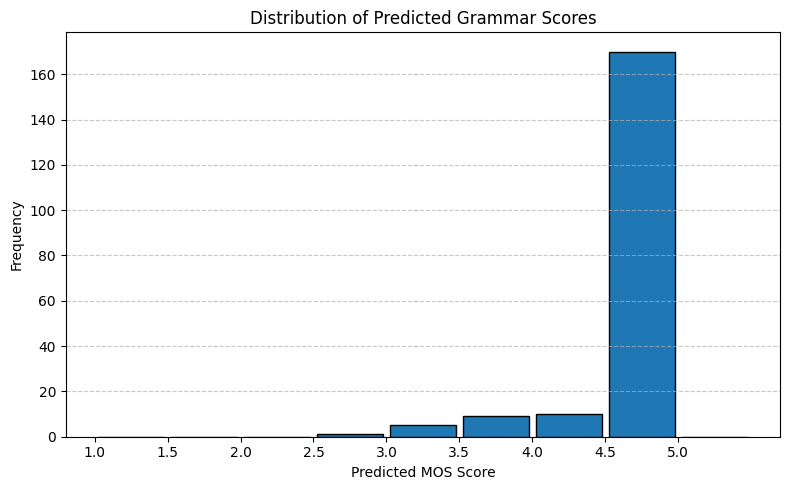

In [ ]:
output_df = pd.read_csv(PREDICTIONS_CSV)
# Plot histogram of predicted labels
plt.figure(figsize=(8, 5))
plt.hist(output_df['label'], bins=[1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5], edgecolor='black', rwidth=0.9)
plt.xticks([1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0])
plt.xlabel("Predicted MOS Score")
plt.ylabel("Frequency")
plt.title("Distribution of Predicted Grammar Scores")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

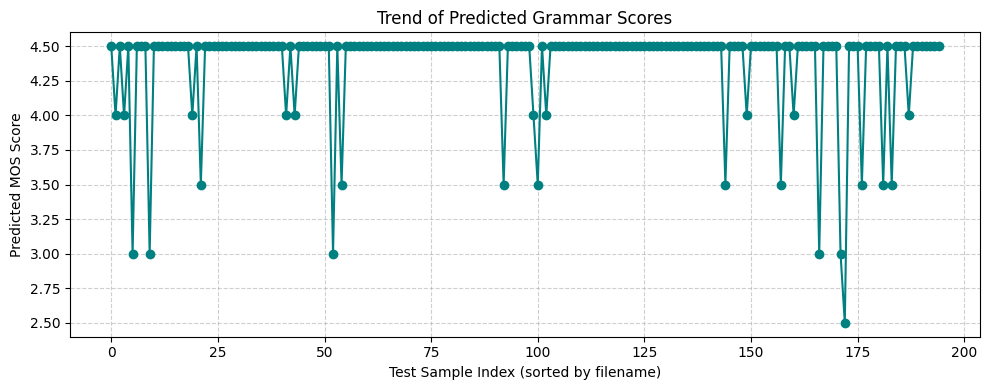

In [12]:
# Sort by filename (or any order) for trendline visualization
df_sorted = output_df.sort_values('filename')

plt.figure(figsize=(10, 4))
plt.plot(df_sorted['label'].values, marker='o', linestyle='-', color='teal')
plt.xlabel("Test Sample Index (sorted by filename)")
plt.ylabel("Predicted MOS Score")
plt.title("Trend of Predicted Grammar Scores")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

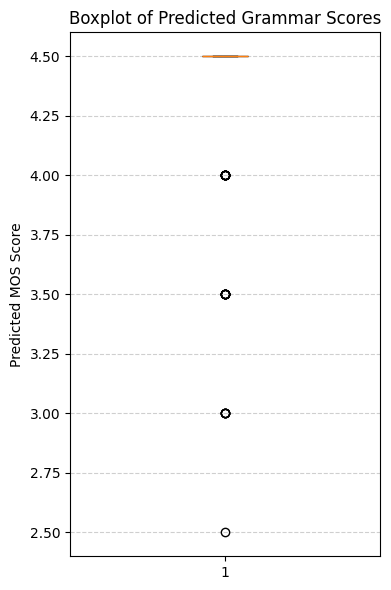

In [13]:
# a statistical summary
plt.figure(figsize=(4, 6))
plt.boxplot(output_df['label'], vert=True, patch_artist=True, boxprops=dict(facecolor='lightblue'))
plt.ylabel("Predicted MOS Score")
plt.title("Boxplot of Predicted Grammar Scores")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()